# Katastrophensimulation - batch-run und Analyse
## Eigene Erweiterung des Systems [Aufgabe 6]

Als Erweiterung des Systems rund um die Simulation wählten wir eine erweiterte Auswertung des Systems.
Dafür nutzten wir die von Mesa bereitgestellten **batch-run** Möglichkeiten, mit welchen die Simulationen sehr oft und effizient ausgeführt werden konnten.
Anschließend wurden die generierten Daten mit **Pandas** in passende Formate umgewandelt und mit **Seaborn** (auf Matplotlib aufbauend) visualisiert.

In [187]:
import seaborn as sns
from schema import *
from typing import Dict, Any, Tuple
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
PICKLE_FILE = "./output/batch_results.pkl"

## Aufsetzen des batch-runs

Für den batch-run können Paramter als Dictionary übergeben werden. Wenn die Parameter keine konstanten Werte, sondern Listen sind, so werden alle möglichen Kombinationen der Parameter durchlaufen. Schnell kann es dadurch zu tausenden Durchläufen kommen. 

In [188]:
# if iterables: tries all possible combinations of the parameters
parameters: Dict = {
    "width": range(8, 25, 2),
    "height": range(8, 25, 2),
    "n_survivors": range(1, 11),
    "n_save_zones": range(1, 11),
    "n_robot_agents": range(1, 7),
    "seed": 42,
}

# calculate the number of iterations for all parameters
count = 1
for key, value in parameters.items():
    # value can be a list or a range
    if isinstance(value, range):
        count *= len(list(value))
    elif isinstance(value, list):
        count *= len(value)
print("Count of combinations:", count)

Count of combinations: 48600


Mit Multiprocessing (Parameter _number\_processes_ von batch_run()) können jedoch mehrere Simulationen gleichzeitig ausgeführt werden, was die Simulationszeit deutlich reduziert. 
_Beispiel für den batch-run: 48600 Simulationen in 1:01:33 ergeben ca. 13 Simulationen pro Sekunde bei der Verwendung von zwölf logischen Prozessoren._

Besonders auffällig ist die hohe Geschwindigkeit der Simulationen bei geringen Höhen und Breiten des Labyrinths im Vergleich zu den hohen Rechendauern bei großen Labyrinthflächen. Vermutlich tritt dieser Unterschied wegen des erhöhten Rechenaufwands beim A-Stern Algorithmus für große Pfadlängen, wie es sie offensichtlich öfter bei großen Labyrinthen gibt, auf. 

Die Daten werden zur Aufbewahrung in einer pickle-Datei gespeichert und nur bei _run\_batch = True_ überschrieben.

In [189]:
# if true -> run batch, save to pickle file in output folder
# if false -> load pickle file from output folder
run_batch = False

In [190]:
if run_batch:
    batch_results = mesa.batch_run(
        model_cls=EnvironmentModel,
        parameters=parameters,
        iterations=1, # for each possible combination of parameters
        number_processes=None,
        data_collection_period=-1,
        display_progress=True,
        max_steps=1000,
    )

In [191]:
df: pd.DataFrame = None

if run_batch:
    # save results to pickle file
    df = pd.DataFrame(batch_results)
    pd.DataFrame.to_pickle(df, PICKLE_FILE)
else:
    # load the results from the pickle file
    try:
        df = pd.DataFrame(pd.read_pickle(PICKLE_FILE))
    except:
        print("batch results not available, file not found, etc.")

print(f"The results have {len(df)} rows and {len(df.columns)} columns.")
print(df.columns)
df.head(2)

The results have 170100 rows and 29 columns.
Index(['RunId', 'iteration', 'Step', 'width', 'height', 'n_survivors',
       'n_save_zones', 'n_robot_agents', 'seed', 'Survivors', 'SaveZones',
       'MazeWidth', 'MazeHeight', 'AllSurvivorsRescued', 'InitialPathlengths',
       'MeanWallDensity', 'HorizontalSymmetry', 'VeticalSymmetry', 'ExitCount',
       'TotalTilesMoved', 'TotalSurvivorsPickedUp', 'TotalSurvivorsPlacedDown',
       'AgentID', 'Tile', 'TransportedSurvivor', 'TilesMoved',
       'SurvivorsPickedUp', 'SurvivorsPlacedDown', 'StillRunning'],
      dtype='object')


,RunId,iteration,Step,width,height,n_survivors,n_save_zones,n_robot_agents,seed,Survivors,...,TotalTilesMoved,TotalSurvivorsPickedUp,TotalSurvivorsPlacedDown,AgentID,Tile,TransportedSurvivor,TilesMoved,SurvivorsPickedUp,SurvivorsPlacedDown,StillRunning
0,6,0,4,8,8,1,2,1,42,[<schema.Survivor object at 0x000002133BAE0470>],...,33,1,0,1,<schema.Tile object at 0x00000213524F22D0>,None,33,1,1,True
1,5,0,4,8,8,1,1,6,42,[<schema.Survivor object at 0x000002133C7B0EF0>],...,96,6,0,1,<schema.Tile object at 0x00000213524F2330>,None,96,1,1,True


## Data transformation

Die Daten werden mit Pandas in einem DataFrame für die Verwendung angepasst.

In [192]:
df.drop(
    [
        "seed", 
        "Survivors", 
        "MazeWidth", 
        "MazeHeight", 
        "AllSurvivorsRescued", 
        "Tile", 
        "StillRunning",
        "AgentID",
        "TransportedSurvivor",
        "TilesMoved"
    ],
    axis=1,
    inplace=True,
)
print(f"The results have reduced {len(df.columns)} columns.")
print(df.columns)

# height * width
df["MazeArea"] = df.apply(lambda x: x["width"] * x["height"], axis=1)

# get pathlengths parameters. only works if data_collection_period is set to 1
df["PathlengthMin"] = df.apply(
    lambda x: EnvironmentModel.get_min_pathlength(x["InitialPathlengths"]),
    axis=1,
)
df["PathlengthMax"] = df.apply(
    lambda x: EnvironmentModel.get_max_pathlength(x["InitialPathlengths"]),
    axis=1,
)
df["PathlengthMean"] = df.apply(
    lambda x: EnvironmentModel.get_mean_pathlength(x["InitialPathlengths"]),
    axis=1,
)

# ratios between TilesMoved and parameters
df["TilesMovedPerSurvivor"] = df.apply(
    lambda x: x["TotalTilesMoved"] / x["n_survivors"] if x["n_survivors"] > 0 else 0, axis=1
)

df["TilesMovedPerSaveZone"] = df.apply(
    lambda x: x["TotalTilesMoved"] / x["n_save_zones"] if x["n_save_zones"] > 0 else 0,
    axis=1,
)

df["TilesMovedPerArea"] = df.apply(
    lambda x: x["TotalTilesMoved"] / x["MazeArea"] if x["MazeArea"] > 0 else 0,
    axis=1,
)
df["TilesMovedPerHeight"] = df.apply(
    lambda x: x["TotalTilesMoved"] / x["height"] if x["height"] > 0 else 0,
    axis=1,
)

df["PathlengthMinPerArea"] = df.apply(
    lambda x: x["PathlengthMin"] / x["MazeArea"] if x["MazeArea"] > 0 else 0,
    axis=1,
)
df["PathlengthMaxPerArea"] = df.apply(
    lambda x: x["PathlengthMax"] / x["MazeArea"] if x["MazeArea"] > 0 else 0,
    axis=1,
)
df["PathlengthMeanPerArea"] = df.apply(
    lambda x: x["PathlengthMean"] / x["MazeArea"] if x["MazeArea"] > 0 else 0,
    axis=1,
)

# grouping of survivor / save zone / robot counts
df["SurvivorCountGroup"] = df.apply(
    lambda x: "Low (<5)" if x["n_survivors"] < 5 else "High (>=5)", axis=1
)
df["SaveZoneCountGroup"] = df.apply(
    lambda x: "Low (<5)" if x["n_save_zones"] < 5 else "High (>=5)", axis=1
)
df["RobotCountGroup"] = df.apply(
    lambda x: "Low (<4)" if x["n_robot_agents"] < 3 else "High (>=4)", axis=1
)

The results have reduced 19 columns.
Index(['RunId', 'iteration', 'Step', 'width', 'height', 'n_survivors',
       'n_save_zones', 'n_robot_agents', 'SaveZones', 'InitialPathlengths',
       'MeanWallDensity', 'HorizontalSymmetry', 'VeticalSymmetry', 'ExitCount',
       'TotalTilesMoved', 'TotalSurvivorsPickedUp', 'TotalSurvivorsPlacedDown',
       'SurvivorsPickedUp', 'SurvivorsPlacedDown'],
      dtype='object')


## Data analysis
### Korrelationsmatrix

Mit einem [Seaborn-Beispiel](https://seaborn.pydata.org/archive/0.11/examples/many_pairwise_correlations.html) wird die Korrelationsmatrix der gesammelten Daten visualisiert.


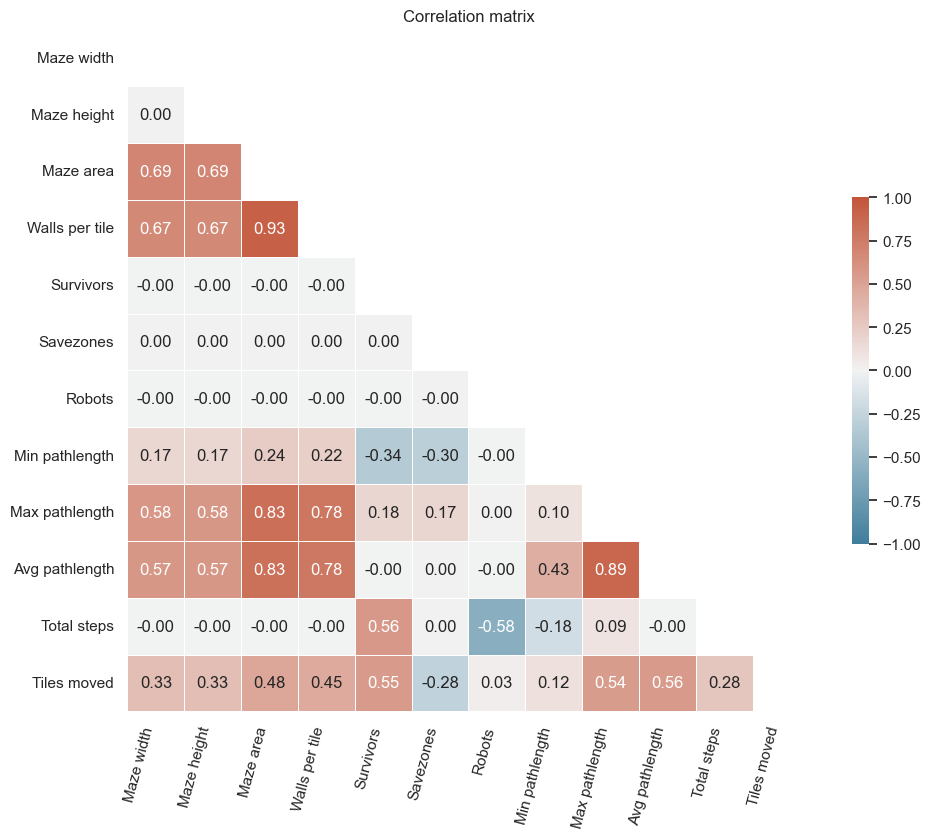

In [193]:
# choose some columns
df_corr = df.reset_index()
df_corr = df_corr[
    [
        "width",
        "height",
        "MazeArea",
        "MeanWallDensity",
        "n_survivors",
        "n_save_zones",
        "n_robot_agents",
        "PathlengthMin",
        "PathlengthMax",
        "PathlengthMean",
        "Step",
        "TotalTilesMoved",
    ]
]
df_corr.rename(
    columns={
        "width": "Maze width",
        "height": "Maze height",
        "MazeArea": "Maze area",
        "MeanWallDensity": "Walls per tile",
        "n_survivors": "Survivors",
        "n_save_zones": "Savezones",
        "n_robot_agents": "Robots",
        "PathlengthMin": "Min pathlength",
        "PathlengthMax": "Max pathlength",
        "PathlengthMean": "Avg pathlength",
        "Step": "Total steps",
        "TotalTilesMoved": "Tiles moved",
    },
    inplace=True,
)

corr = df_corr.corr()

# Correlation matrix with mask for upper triangle
sns.set_theme(style="white")
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=1,
    vmin=-1,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    annot=True,
    fmt=".2f",
)
plt.title("Correlation matrix")
plt.xticks(rotation=75, ha="right")
plt.savefig("./output/correlation_heatmap.png", dpi=300, bbox_inches="tight");

Aus der **Korrelationsmatrix** werden folgende Zusammenhänge ersichtlich:

### Simulationsschritte
Offensichtlich hängt die Anzahl der **Simulationsschritte** "Total steps" nicht von der Höhe, Breite oder der Anzahl der SaveZones ab, sondern nur von der Anzahl der zu rettenden Überlebenden und der bereitgestellten Roboter. Wäre die Bewegungsreichweite der Roboter pro Simulationsschritt begrenzt, so würde hier eine von den Paramtern dargestellt werden können.

### Wanddichte x Pfadlänge

Interessant ist der Zusammenhang zwischen der Dichte als **Wände pro Feld** des Labyrinths "Walls per tile" mit der maximalen, bzw. durchschnittlichen, **Pfadlänge** "Max/Avg pathlength" mit einem Korrelationskoeffizienten von ca. 0,8.

Visualisiert man den Zusammenhang als Lineplot (siehe unten), so zeigt sich, dass trotz nur minimaler Änderungen der Dichte der Wände pro Feld, die Pfadlängen sehr stark variieren.
Deskriptiv bedeutet das, dass mit steigender Anzahl an (relevanten) Wänden pro Feld, die durchschnittliche und maximale Pfadlänge ansteigt. 

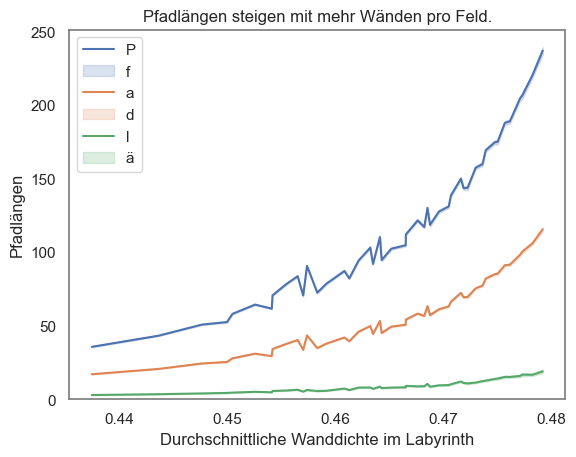

In [194]:
sns.lineplot(data=df, x="MeanWallDensity", y="PathlengthMax", label="Max. Pfadlänge")
sns.lineplot(data=df, x="MeanWallDensity", y="PathlengthMean", label="Avg. Pfadlänge")
sns.lineplot(data=df, x="MeanWallDensity", y="PathlengthMin", label="Min. Pfadlänge")

plt.title("Pfadlängen steigen mit mehr Wänden pro Feld.")
plt.xlabel("Durchschnittliche Wanddichte im Labyrinth")
plt.ylabel("Pfadlängen")
plt.legend("Pfadlängen")

plt.ylim(bottom=0)
for side in ["top", "bottom", "left", "right"]:
    plt.gca().spines[side].set_color("gray")

plt.savefig("./output/wall_density_pathlengths.png", dpi=300, bbox_inches="tight")

Dieses Verhalten wird im Folgenden genauer analysiert:

Normale Passagen (z.B. ein Weg von links nach rechts) haben zwei Wände und zwei offene Wege im Labyrinth. Sackgassen haben drei Wände, von einer Seite kann hergekommen werden. Wege, die zu einer Sackgasse führen, können maximal eine Wand haben, da ein Weg durch sie durchführt und sie eine Abzweigung zur Sackgasse haben. Ausgänge müssen mindestens einen Ort der Herkunft haben, sowie am Rand eine Öffnung, bzw. an einer Ecke zwei Öffnungen. Die Öffnungen zum Rand sind jedoch nicht relevant, da sie nicht zu anderen Feldern zugewandt sind; sie sollten daher nicht mitgezählt werden. Ein Feld an der Ecke kann theoretisch maximal nur zwei relevante Wände haben, da die Wände in das Leere nicht mitgezählt werden. Je mehr Randkästchen vorhanden sind, desto mehr weniger Wände können maximal auftreten.

_Als Beispiel: Ein 2x2 Labyrinth hat vier Felder, wobei zwischen den Feldern maximal vier Wände gesetzt werden können - in diesem Fall wäre das Labyrinth unlösbar. Die acht Wände zu den Rändern werden dabei nicht mitgezählt._

Daraus lässt sich ableiten: Generell sollte sich die durchschnittliche Anzahl der Wände in einem unendlich großen Labyrinth ohne Ausgänge und ohne Sackgassen zwei annähern, da das gesamte Labyrinth eine einzige Passage ohne Abzweigungen und Stops ist und der Einfluss der Ränder nicht mitgezählt wird.
Das verdeutlicht auch der folgende Graph, wobei die Wanddichte die Anzahl der gesetzten Wände pro Feld entsprechen. Die Wanddichte nähert sich somit dem Wert 0,5 an, da gegen unendlich angenähert, zwei von vier Wänden gesetzt sind.

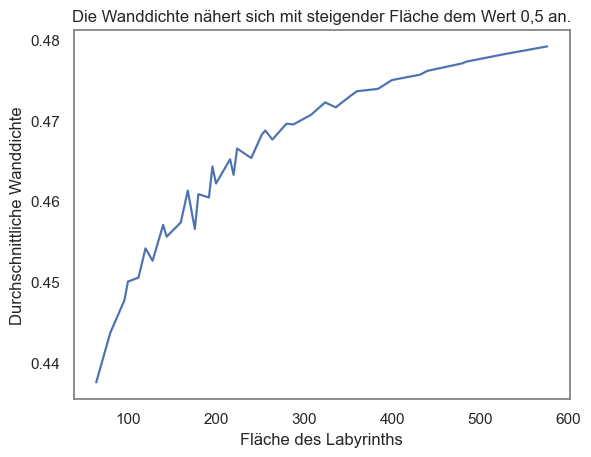

In [195]:
sns.lineplot(data=df, x="MazeArea", y="MeanWallDensity")

plt.title("Die Wanddichte nähert sich mit steigender Fläche dem Wert 0,5 an.")
plt.xlabel("Fläche des Labyrinths")
plt.ylabel("Durchschnittliche Wanddichte")

for side in ["top", "bottom", "left", "right"]:
    plt.gca().spines[side].set_color("gray")

plt.savefig("./output/walldensity_per_area_konverging.png", dpi=300, bbox_inches="tight")

Werden die Ränder mitgezählt, also wenn das Labyrinth nicht unendlich groß ist, so wird die durchschnittliche Anzahl der Wände pro Feld unter zwei fallen, da an Randpositionen generell weniger Wände möglich sind. 
_Wenn die Höhe um eins erhöht wird, so steigt die Anzahl der Wände um zwei an, da an der linken und rechten Seite jeweils eine Wand gesetzt wird. Gleichzeitig erhöht sich die Anzahl der Nicht-Rand-Felder um Breite - 2._

Mit geringerer Labyrinthgröße sinkt somit die durchschnittliche Anzahl der Wände pro Feld und somit die Wanddichte. Mit steigender Fläche geht somit eine steigende Wanddichte einher - die Parameter korrelieren nach der Korrelationsmatrix mit einem Wert von ca. 0,9 miteinander.

Mit größeren Flächen werden auch öfter Sackgassen durch den iterativen Ansatz des random DFS erzeugt. Perfekte Labyrinthe mit zwei Ausgängen (als Start und Ziel) und ohne Sackgassen haben eine maximale Pfadlänge zwischen zwei Punkten von der Anzahl der insgesamten Felder im Labyrinth, da es nur einen Pfad vom Eingang (Punkt 1) zum Ausgang (Punkt 2) gibt.
Sackgassen führen im Allgemeinen zu einer Verschachtelung des Labyrinths, reduzieren jedoch im Vergleich zu dem Labyrinth mit einer einzigen Passage die effektiv nötige Pfadlänge. Das resultiert aus der Tatsache, dass manche Felder, die der einzigen langen Passage zwischen Eingang und Ausgang angehören könnten, stattdessen als Sackgasse verwendet werden. Wird der Weg zwischen zwei Punkten (z.B. Eingang und Ausgang) nun betrachtet, so können die Sackgassen dazwischen für die Pfadlänge ignoriert werden; als Folge sinkt die insgesamt benötigte maximale und durchschnittliche Pfadlänge. Das lässt sich auch in dem Graphen zum Verlauf der minimalen, durchschnittlichen und maximalen Pfadlänge pro Flächeneinheit (FE) auf die Fläche des Labyrinths erkennen.

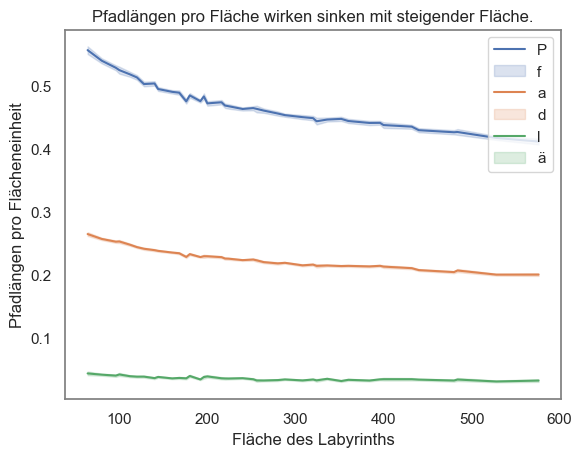

In [196]:
sns.lineplot(data=df, x="MazeArea", y="PathlengthMaxPerArea", label="Max. Pfadlänge pro FE")
sns.lineplot(data=df, x="MazeArea", y="PathlengthMeanPerArea", label="Avg. Pfadlänge pro FE")
sns.lineplot(data=df, x="MazeArea", y="PathlengthMinPerArea", label="Min. Pfadlänge pro FE")

plt.title("Pfadlängen pro Fläche wirken sinken mit steigender Fläche.")
plt.xlabel("Fläche des Labyrinths")
plt.ylabel("Pfadlängen pro Flächeneinheit")
plt.legend("Pfadlängen pro Fläche")

for side in ["top", "bottom", "left", "right"]:
    plt.gca().spines[side].set_color("gray")

plt.savefig(
    "./output/pathlengths_per_area.png", dpi=300, bbox_inches="tight"
)

Bei steigenden Flächen werden somit mehr Sackgassen erzeugt, wodurch die Pfadlängen sinken, wobei das offensichtlich kein perfekt linearer Zusammenhang ist. 

Gleichzeitig steigt die Wanddichte, da mehr Wände pro Feld gesetzt werden können. 
Daraus ergibt sich die hohe Korrelation zwischen der Wanddichte und der durchschnittlichen/maximalen Pfadlänge mit einem Wert von ca. 0,8.

### Anzahl der bewegten Felder

#### Bewegte Felder x offensichtliche Parameter

Die Anzahl der bewegten Felder "Tiles moved" steigt natürlich mit der Höhe und Breite des Labyrinths an, wie das auch die Korrelationsmatrix bestätigt. 

Wie zuvor gefolgert, steigen die maximalen und durchschnittlichen Pfadlängen mit höheren Wanddichten an. Diese Pfadlängen - als Anzahl der Felder von jeder Savezone zu jedem Überlebenden definiert - führen somit direkt zu einer Erhöhung der Anzahl der bewegten Felder. Somit korrelieren die Wanddichte, sowie die maximale und durchschnittliche Pfadlänge mit der Anzahl der bewegten Felder.

#### Bewegte Felder x Anzahl Überlebende

Offensichtlich steigt die Anzahl der bewegten Felder mit der Anzahl der Überlebenden an.
Leicht auffällig ist dabei die minimale Degressivität des Graphen bei steigender Anzahl der Überlebenden.

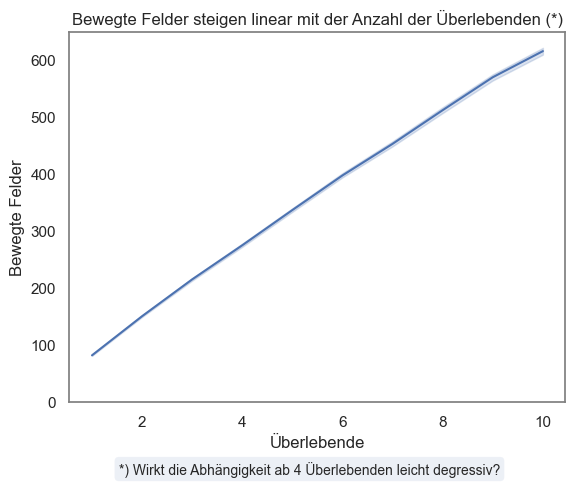

In [197]:
sns.lineplot(data=df, x="n_survivors", y="TotalTilesMoved")

plt.title("Bewegte Felder steigen linear mit der Anzahl der Überlebenden (*)")
plt.xlabel("Überlebende")
plt.ylabel("Bewegte Felder")
plt.ylim(bottom=0)
for side in ["top", "bottom", "left", "right"]:
    plt.gca().spines[side].set_color("gray")

plt.figtext(
    0.5,
    -0.04,
    "*) Wirkt die Abhängigkeit ab 4 Überlebenden leicht degressiv?",
    wrap=True,
    horizontalalignment="center",
    fontsize=10,
    bbox=dict(boxstyle="round", alpha=0.1),
)

plt.savefig("./output/tiles_moved_per_survivor.png", dpi=300, bbox_inches="tight")

Eine Vermutung für den leichten Abfall der linearen Abhängigkeit der bewegten Felder von der Anzahl der Überlebenden wäre, dass die Roboter bei mehr Überlebenden generell kürzere Pfade finden können, da es auch mehr Auswahlmöglichkeiten gibt.

Bestätigen könnte man diese These, wenn eine erhöhte Anzahl Überlebenden pro bewegten Feldern einen reduzierenden Effekt auf die bewegten Felder und somit die Pfadlängen haben sollten.

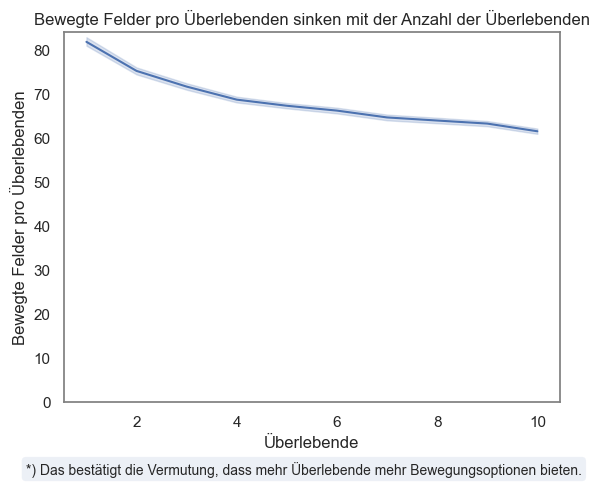

In [198]:
sns.lineplot(data=df, x="n_survivors", y="TilesMovedPerSurvivor")

plt.title("Bewegte Felder pro Überlebenden sinken mit der Anzahl der Überlebenden")
plt.xlabel("Überlebende")
plt.ylabel("Bewegte Felder pro Überlebenden")
plt.ylim(bottom=0)
for side in ["top", "bottom", "left", "right"]:
    plt.gca().spines[side].set_color("gray")

plt.figtext(
    0.5,
    -0.04,
    "*) Das bestätigt die Vermutung, dass mehr Überlebende mehr Bewegungsoptionen bieten.",
    wrap=True,
    horizontalalignment="center",
    fontsize=10,
    bbox=dict(boxstyle="round", alpha=0.1),
)

plt.savefig("./output/tiles_moved_per_survivor_on_survivor.png", dpi=300, bbox_inches="tight")

Es wird Erkenntlich, dass mehr Überlebende generell zu weniger bewegten Feldern pro Überlebenden führen.
Das lässt sich auch mit der Anzahl der Savezones beweisen, die die optimalen Pfadlängen zwischen Roboter (startend von den Savezones) und den Überlebenden mindern.

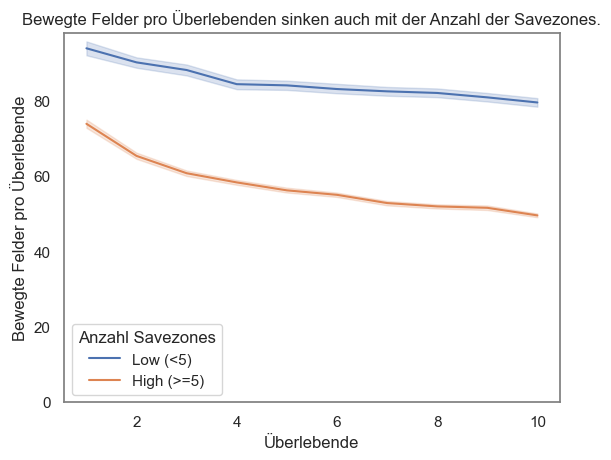

In [199]:
sns.lineplot(data=df, x="n_survivors", y="TilesMovedPerSurvivor", hue="SaveZoneCountGroup")

plt.title("Bewegte Felder pro Überlebenden sinken auch mit der Anzahl der Savezones.")
plt.xlabel("Überlebende")
plt.ylabel("Bewegte Felder pro Überlebende")
plt.ylim(bottom=0)
plt.legend(title="Anzahl Savezones")
for side in ["top", "bottom", "left", "right"]:
    plt.gca().spines[side].set_color("gray")

plt.savefig("./output/tiles_moved_per_survivor_on_savezones.png", dpi=300, bbox_inches="tight")

Aus der Grafik wird ersichtlich, dass mehr Savezones (>=5) zu einer Reduzierung der bewegten Felder pro Überlebenden führen.

Fraglich dabei ist, ob die Anzahl der Roboter auch einen positiven Einfluss auf die Pfadlängen hat. Die Vermutung wäre, dass sich Roboter wegen des gegenseitigen Wegnehmens des nähesten Überlebenden im Allgemeinen mehr bewegen müssen, schließlich steigen die Pfadlängen, wenn eine weniger optimale Lösung mit dem A-Stern Algorithmus gefunden wird.

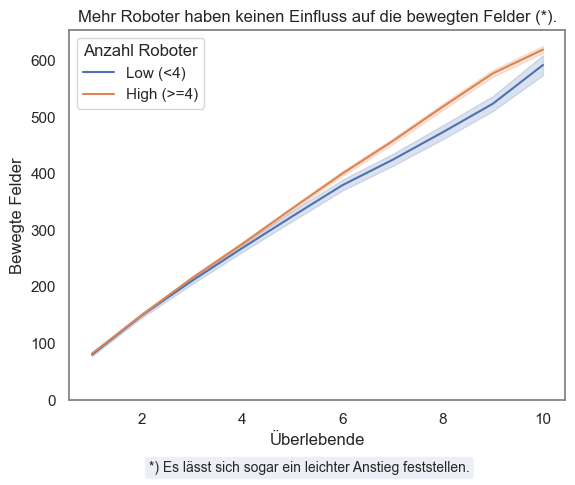

In [200]:
sns.lineplot(data=df, x="n_survivors", y="TotalTilesMoved", hue="RobotCountGroup")
plt.title("Mehr Roboter haben keinen Einfluss auf die bewegten Felder (*).")
plt.xlabel("Überlebende")
plt.ylabel("Bewegte Felder")
plt.ylim(bottom=0)

plt.legend(title="Anzahl Roboter")
plt.figtext(
    0.5,
    -0.04,
    "*) Es lässt sich sogar ein leichter Anstieg feststellen.",
    wrap=True,
    horizontalalignment="center",
    fontsize=10,
    bbox=dict(boxstyle="round", alpha=0.1),
)

for side in ["top", "bottom", "left", "right"]:
    plt.gca().spines[side].set_color("gray")

plt.savefig(
    "./output/tiles_moved_per_survivor_grouped_robots.png", dpi=300, bbox_inches="tight"
)

Offensichtlich läuft die Simulation mit weniger Simulationsschritten ab, da mehr Roboter zur Verfügung stehen.

Die insgesamte Anzahl der bewegten Felder als Summe der zurückgelegten Felder pro Roboter steigt jedoch ab einer Anzahl von 4 Robotern leicht an.
Das bestätigt die Vermutung, dass die Roboter sich gegenseitig die optimalen Überlebenden und somit kürzesten Pfade wegnehmen. Bei einer Realwelt-Implementierung sollte deshalb auf geeigntete Kommunikation und Koordination zwischen den Robotern geachtet werden, um die Suchzeit zu reduzieren.

Mehr Roboter haben somit keinen positiven Einfluss auf die Pfadlängen, sondern erhöhen diese sogar wahrnehmbar.

### Simulationsschritte x Roboter

Natürlich sinkt die Anzahl der Simulationsschritte mit steigender Anzahl der Roboter, da die Überlebenden von mehreren Robotern gleichzeitig gerettet werden können.
In diesem Sinne halbiert sich die Anzahl der Simulationsschritte mit doppelter Anzahl von Robotern, wenn die Anzahl der Übelebenden nur groß genug ist. Das zeigt sich beispielsweise im Graphen im Schritt von einen auf zwei Robotern.

Bei sehr vielen oder mehr Robotern als Überlebenden, nähern sich die Simulationsschritte dem Wert 4 an. Das folgt aus der Folge der minimal vier Aktionen der Roboter:

- zu Überlebenden bewegen
- Überlebenden aufsammeln
- zu Savezone bewegen
- Überlebenden absetzen, Wiederhole von Anfang.

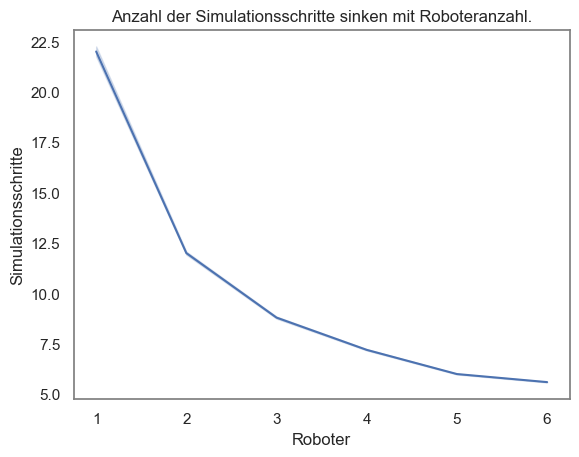

In [201]:
sns.lineplot(data=df, x="n_robot_agents", y="Step")

plt.title("Anzahl der Simulationsschritte sinken mit Roboteranzahl.")
plt.xlabel("Roboter")
plt.ylabel("Simulationsschritte")

for side in ["top", "bottom", "left", "right"]:
    plt.gca().spines[side].set_color("gray")

plt.savefig(
    "./output/simulationsteps_per_agent.png",
    dpi=300,
    bbox_inches="tight",
)

### Pfadlängen x Savezones

Natürlich sinken die minimalen Pfadlängen zwischen Savezones und Überlebenden mit steigender Anzahl der Savezones, da mehr Möglichkeiten für kürzere (optimale) Pfade zur Verfügung stehen.
Gleichzeitig steigen die maximalen Pfadlängen an, da die längsten (inoptimalsten) Pfade wahrscheinlicher werden. 
Dennoch profitiert der Roboter bei der Katastrophenrettung von einer höheren Anzahl an Savezones, da es mehr kürzere (optimale) Pfade gibt, die genutzt werden können.

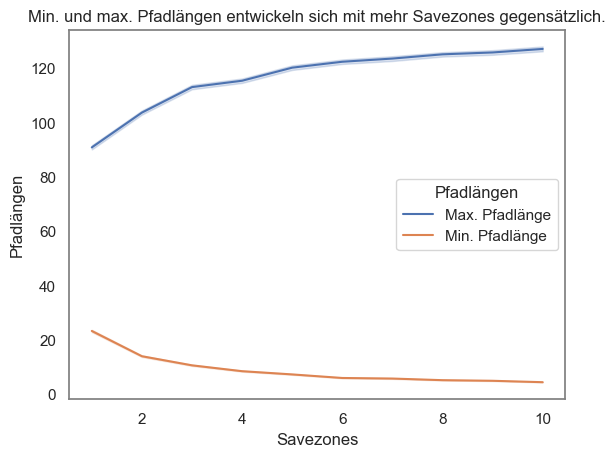

In [202]:
sns.lineplot(data=df, x="n_save_zones", y="PathlengthMax", label="Max. Pfadlänge")
sns.lineplot(data=df, x="n_save_zones", y="PathlengthMin", label="Min. Pfadlänge")

plt.title("Min. und max. Pfadlängen entwickeln sich mit mehr Savezones gegensätzlich.")
plt.xlabel("Savezones")
plt.ylabel("Pfadlängen")

plt.legend(title="Pfadlängen")

for side in ["top", "bottom", "left", "right"]:
    plt.gca().spines[side].set_color("gray")

plt.savefig(
    "./output/savezones_maxpathlengths_grouped_survivors.png",
    dpi=300,
    bbox_inches="tight",
)

In wirklichen Rettungsszenarien sollte deshalb darauf geachtet werden, nicht zu wenige Savezones zu allokieren, um die Pfadlängen und damit die bewegte Distanz der Roboter zu minimieren.